# Kaggle - Santander Product Recommendation

## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ctypes
import gc
from tqdm import tqdm
import pickle
from scipy import stats
import collections

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Santander product recommendation/train_ver2.csv')
#/content/drive/MyDrive/Santander product recommendation/train_ver2.csv

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_test = pd.read_csv('/content/drive/MyDrive/Santander product recommendation/test_ver2.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Optimizing column data types to reduce memory usage 

In [4]:
#This function reduces memory usage of numeric features by changing their data types to the least possible numeric data type.

#https://towardsdatascience.com/how-to-work-with-million-row-datasets-like-a-pro-76fb5c381cdd
def reduce_memory_usage(df, verbose=True):
    numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print(
            "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                end_mem, 100 * (start_mem - end_mem) / start_mem
            )
        )
    return df

In [5]:
df = reduce_memory_usage(df)

Mem. usage decreased to 2342.72 Mb (53.1% reduction)


In [6]:
df_test = reduce_memory_usage(df_test)

Mem. usage decreased to 122.34 Mb (28.1% reduction)


In [7]:
#Converting date features to datetime format

df['fecha_dato'] = pd.to_datetime(df.fecha_dato)
df['fecha_alta'] = pd.to_datetime(df.fecha_alta)

df_test['fecha_dato'] = pd.to_datetime(df_test.fecha_dato)
df_test['fecha_alta'] = pd.to_datetime(df_test.fecha_alta)

## EDA

In [10]:
df

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0.0,6,1.0,NaN,1,A,S,N,NaN,KHL,N,1.0,29.0,MALAGA,1.0,87218.101562,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,S,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,35548.738281,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,13.0,CIUDAD REAL,0.0,122179.109375,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0.0,35,1.0,NaN,1,I,S,N,NaN,KHD,N,1.0,50.0,ZARAGOZA,0.0,119775.539062,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0.0,35,1.0,NaN,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13647304,2016-05-28,1166765,N,ES,V,22,2013-08-14,0.0,33,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,0.0,43912.171875,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647305,2016-05-28,1166764,N,ES,V,23,2013-08-14,0.0,33,1.0,NaN,1,I,S,N,NaN,KHE,N,1.0,26.0,"RIOJA, LA",0.0,23334.990234,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647306,2016-05-28,1166763,N,ES,H,47,2013-08-14,0.0,33,1.0,NaN,1,A,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,1.0,NaN,02 - PARTICULARES,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647307,2016-05-28,1166789,N,ES,H,22,2013-08-14,0.0,33,1.0,NaN,1.0,I,S,N,NaN,KHE,N,1.0,50.0,ZARAGOZA,0.0,199592.812500,03 - UNIVERSITARIO,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0


# Data Cleaning

In [11]:
# Count of null values for each feature
df.isnull().sum()

fecha_dato                      0
ncodpers                        0
ind_empleado                27734
pais_residencia             27734
sexo                        27804
age                             0
fecha_alta                  27734
ind_nuevo                   27734
antiguedad                      0
indrel                      27734
ult_fec_cli_1t           13622516
indrel_1mes                149781
tiprel_1mes                149781
indresi                     27734
indext                      27734
conyuemp                 13645501
canal_entrada              186126
indfall                     27734
tipodom                     27735
cod_prov                    93591
nomprov                     93591
ind_actividad_cliente       27734
renta                     2794375
segmento                   189368
ind_ahor_fin_ult1               0
ind_aval_fin_ult1               0
ind_cco_fin_ult1                0
ind_cder_fin_ult1               0
ind_cno_fin_ult1                0
ind_ctju_fin_u

Filling NaN values of '**ind_nomina_ult1**' and '**ind_nom_pens_ult1**' with zero

In [12]:
df.fillna(value={'ind_nomina_ult1':0,'ind_nom_pens_ult1':0},inplace=True)

Add new column '**days**' which signifies number of days since customer first joined the bank

In [13]:
days_column = (df['fecha_dato'] - df['fecha_alta']).dt.days

#generate new column 'days' from 
df.insert(loc=6, column='days', value=days_column)

#Drop the 'fetch_alta' column
df.drop(columns=['fecha_alta'],inplace = True)

column **ult_fec_cli_1t** 

In [14]:
#replace null values with 0 & rest with 1
df['ult_fec_cli_1t'] = df['ult_fec_cli_1t'].apply(lambda x: 1 if pd.notnull(x) else 0)

column **tipodom**

In [15]:
# remove column tipodom because it has the same value for all customers
df.drop(columns=['tipodom'],inplace = True)

column **cod_prov**

In [16]:
#cod_prov is a duplicate column to nomprov
df.drop(columns=['cod_prov'],inplace = True)

In [17]:
#converting the ' NA' values to nan
df['age'] = pd.to_numeric(df['age'], errors='coerce')

In [18]:
#converting the ' NA' values to nan
df['antiguedad'] = pd.to_numeric(df['antiguedad'], errors='coerce')

In [19]:
df[
   df['ind_empleado'].isnull() & 
   df['pais_residencia'].isnull() & 
   df['sexo'].isnull() & 
   df['ind_nuevo'].isnull() & 
   df['indrel'].isnull()
   ]

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,days,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
261,2015-01-28,1050741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1029,2015-01-28,1051017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1063,2015-01-28,1051064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1154,2015-01-28,1051387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1779,2015-01-28,1048660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3775976,2015-06-28,550081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0
3776175,2015-06-28,550693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0
3776230,2015-06-28,549518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0
3776279,2015-06-28,549207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.0,0.0,0


**Observation**:
1. Some Customers from Jan-2015 to June-2015 have no Demographic data.
2. But they have purchased bank products so we cannot remove these customer data.
3. We'll keep these '**nan**' data and treat them as a category in itself.

Grouping the dataset on **customer id** to get the demographic data of each customer.

In [21]:
df_group = df.groupby('ncodpers').agg({'ind_empleado': lambda x: x.iloc[-1],
                            'pais_residencia': lambda x: x.iloc[-1],
                            'sexo': lambda x: x.iloc[-1],
                            'age': lambda x: x.iloc[-1],
                            'antiguedad': lambda x: x.iloc[-1],
                            'indrel': lambda x: x.iloc[-1],
                            'indrel_1mes': lambda x: x.iloc[-1],
                            'tiprel_1mes': lambda x: x.iloc[-1],
                            'indresi': lambda x: x.iloc[-1],
                            'indext': lambda x: x.iloc[-1],
                            'conyuemp': lambda x: x.iloc[-1],
                            'canal_entrada': lambda x: x.iloc[-1],
                            'indfall': lambda x: x.iloc[-1],
                            'days': lambda x: x.iloc[-1],
                            'nomprov': lambda x: x.iloc[-1],
                            'ind_actividad_cliente': lambda x: x.iloc[-1],
                            'renta': lambda x: x.iloc[-1],
                            'segmento': lambda x: x.iloc[-1],
                            })

In [22]:
df_group

,ind_empleado,pais_residencia,sexo,age,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,days,nomprov,ind_actividad_cliente,renta,segmento
ncodpers,,,,,,,,,,,,,,,,,,
15889,F,ES,V,56.0,255.0,1.0,1,A,S,N,N,KAT,N,7803.0,MADRID,1.0,326124.906250,01 - TOP
15890,A,ES,V,63.0,256.0,1.0,1,A,S,N,N,KAT,N,7803.0,MADRID,1.0,71461.203125,01 - TOP
15891,N,ES,H,59.0,246.0,99.0,1,A,S,N,N,KAT,N,31.0,MADRID,0.0,NaN,02 - PARTICULARES
15892,F,ES,H,62.0,256.0,1.0,1,A,S,N,N,KAT,N,7803.0,MADRID,1.0,430477.406250,01 - TOP
15893,N,ES,V,63.0,256.0,1.0,1,A,S,N,N,KAT,N,6812.0,MADRID,1.0,430477.406250,02 - PARTICULARES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,N,ES,V,52.0,0.0,1.0,NaN,NaN,S,N,NaN,NaN,N,-3.0,CIUDAD REAL,0.0,NaN,NaN
1553686,N,ES,H,30.0,0.0,1.0,NaN,NaN,S,S,NaN,NaN,N,-3.0,SEVILLA,0.0,NaN,NaN
1553687,N,ES,V,21.0,0.0,1.0,NaN,NaN,S,N,NaN,NaN,N,-3.0,MADRID,0.0,NaN,NaN


In [23]:
df_group = pd.DataFrame(df_group).reset_index()

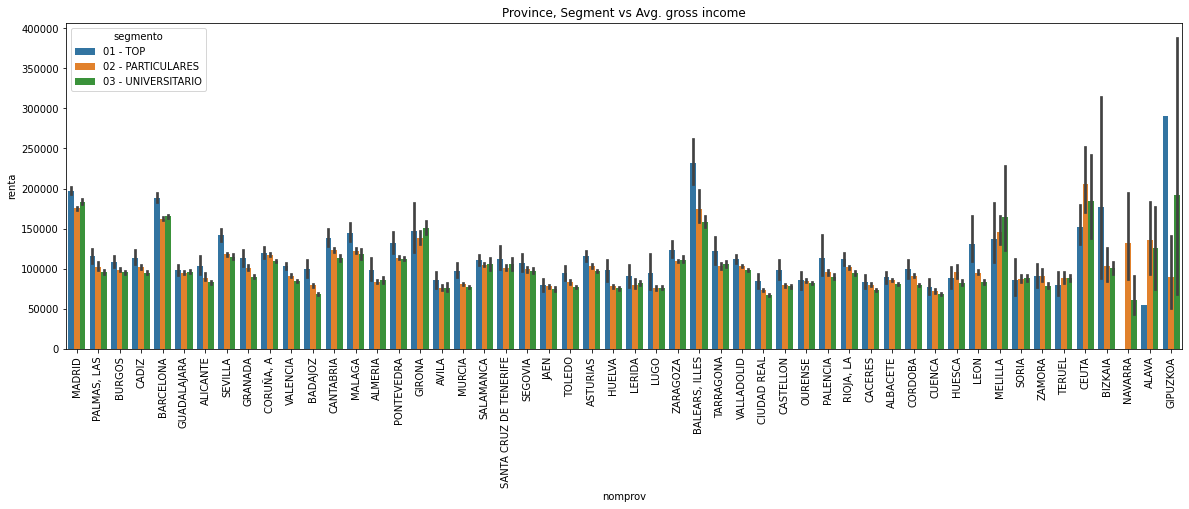

In [24]:
# Plot to find average yearly income of customers by their province and the segment they belong to
plt.figure(figsize=(20,6))
sns.barplot(x="nomprov", y="renta",data = df_group[(~df_group['renta'].isnull()) & (~df_group['segmento'].isnull()) & (~df_group['nomprov'].isnull())],hue = "segmento")
plt.xticks(rotation ='vertical')
plt.title('Province, Segment vs Avg. gross income')
plt.show()

**Observation**
1. On an average most province customers have yearly income of the following oder :- VIP(TOP) > Individuals(Particulares) > College graduated(Universitario)

### Filling yearly income missing data



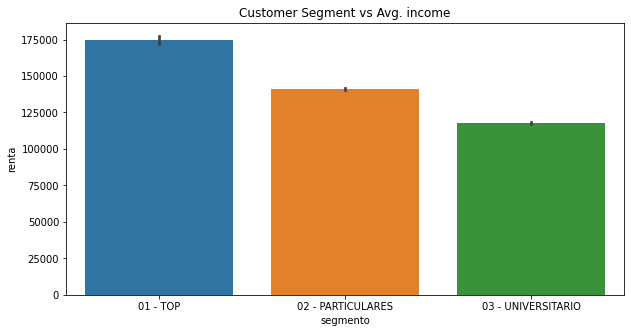

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(x="segmento", y="renta", data=df_group[(~df_group['segmento'].isnull()) & (~df_group['renta'].isnull())])
plt.ticklabel_format(style = 'plain',axis = 'y')
plt.title('Customer Segment vs Avg. income')
plt.show()

**Observations**
1. On an average **VIP**s earn the highest.
2. **Individuals** earn less than **VIP**s
3. and **College Graduated** earn less than **Individuals**

In [26]:
# Average yearly income per segment per province
prov_segmento_mean = df_group[(~df_group['renta'].isnull()) & (~df_group['segmento'].isnull()) & (~df_group['nomprov'].isnull())].groupby(['nomprov','segmento']).renta.mean()

# Overall average yearly income per segment of customer 
segmento_renta_mean = df_group[(~df_group['renta'].isnull()) & (~df_group['segmento'].isnull()) & (~df_group['nomprov'].isnull())].groupby('segmento').renta.mean()

# Dataframe indeces of customers who have province and segment name but "null" yearly income
null_indexes = df_group[(~df_group['nomprov'].isnull()) & (~df_group['segmento'].isnull()) & (df_group['renta'].isnull())].index

#Filling those null indices  with avg. yearly income of every province per segment.
for i in tqdm(null_indexes):
    try:
        if prov_segmento_mean[df_group.iloc[i,14]][df_group.iloc[i,17]]:
            df_group.iloc[i,16] = prov_segmento_mean[df_group.iloc[i,14]][df_group.iloc[i,17]]
    except:
        df_group.iloc[i,16] = segmento_renta_mean['01 - TOP']

100%|██████████| 226749/226749 [04:48<00:00, 784.61it/s]


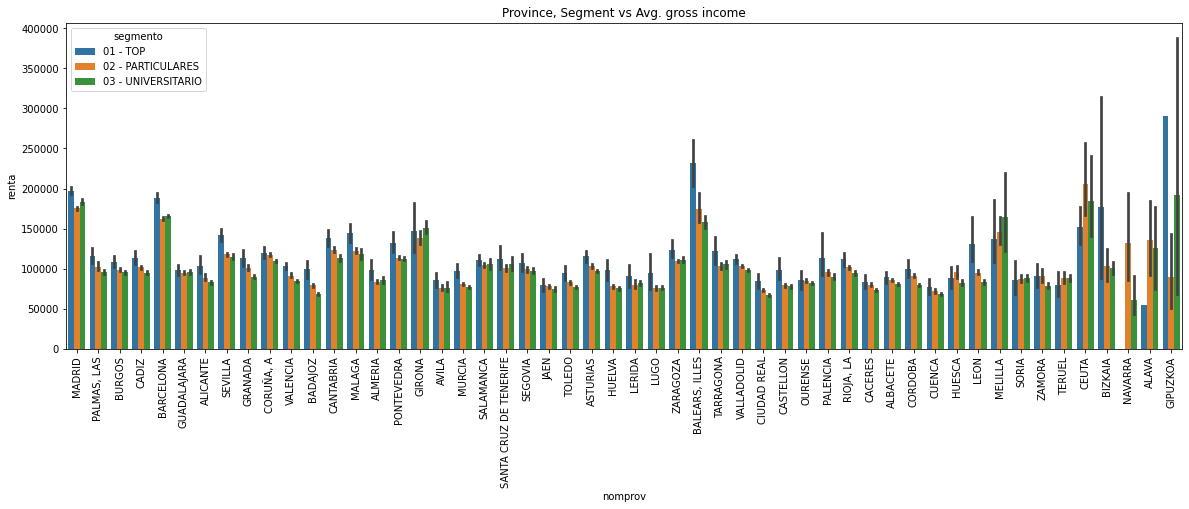

In [27]:
#plot after filling the yearly income column
plt.figure(figsize=(20,6))
sns.barplot(x="nomprov", y="renta",data = df_group[(~df_group['renta'].isnull()) & (~df_group['segmento'].isnull()) & (~df_group['nomprov'].isnull())],hue = "segmento")
plt.xticks(rotation ='vertical')
plt.title('Province, Segment vs Avg. gross income')
plt.show()

## Univariate Analysis

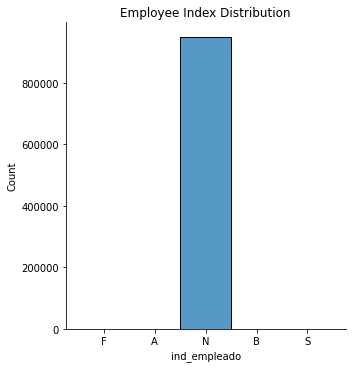

In [29]:
sns.displot(df_group['ind_empleado'])
plt.title('Employee Index Distribution')
plt.show()

**Observation**
1. Most customers are **not** an employee of the bank

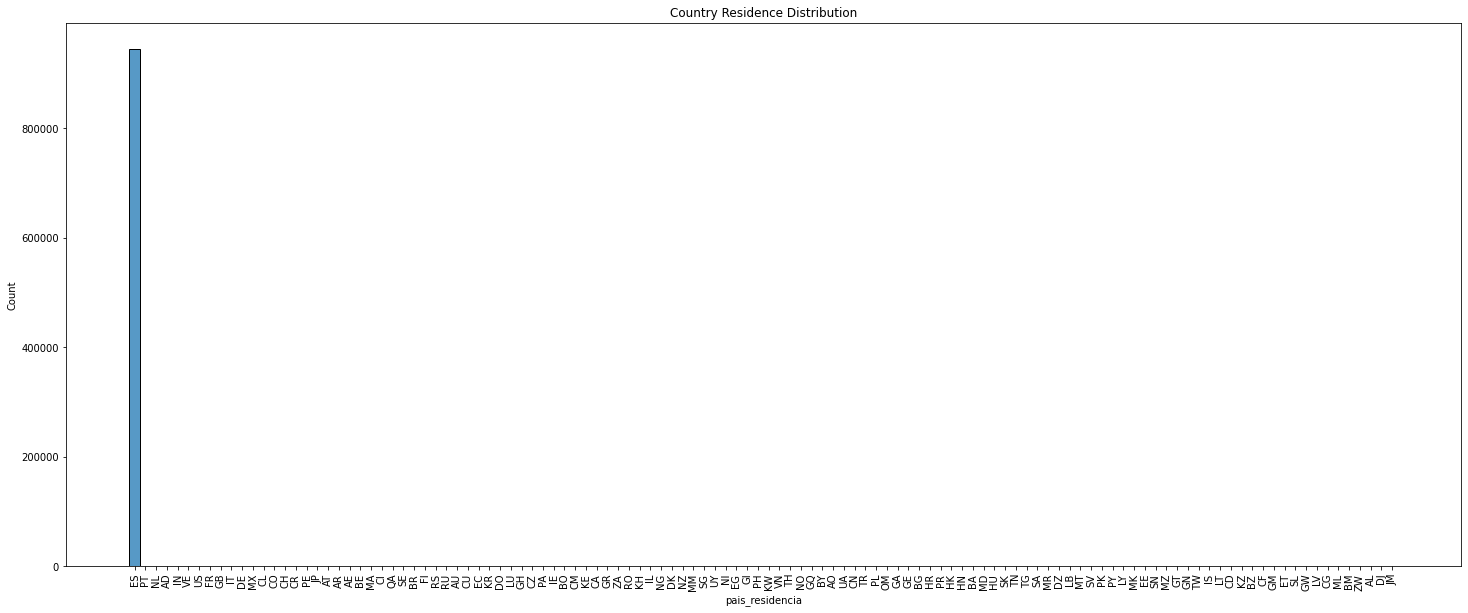

In [30]:
plt.figure(figsize=(25,10))
sns.histplot(df_group['pais_residencia'])
plt.title('Country Residence Distribution')
plt.xticks(rotation ='vertical')
plt.show()

**Observation**
1. Most customers reside in the country '**ES**'

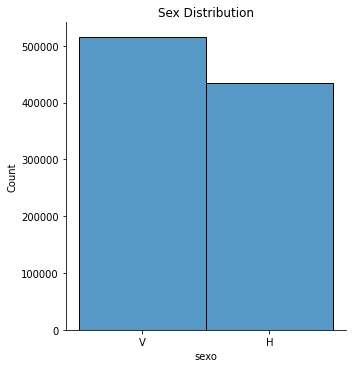

In [31]:
sns.displot(df_group['sexo'])
plt.title('Sex Distribution')
plt.show()

**Observation**
1. Number of custmers with sex '**V**' is slightly more than '**H**'

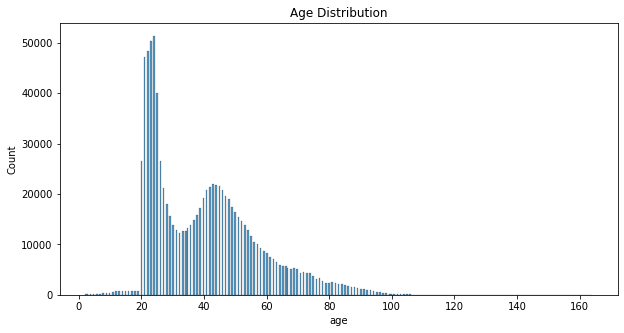

In [32]:
plt.figure(figsize=(10,5))
sns.histplot(df_group['age'])
plt.title('Age Distribution')
plt.show()

**Observation**
1. Number of customers below the age of 20 are very less
2. Most customers are in the age group **20-100**
3. Number of customers between the age group **20-25** is maximum. 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


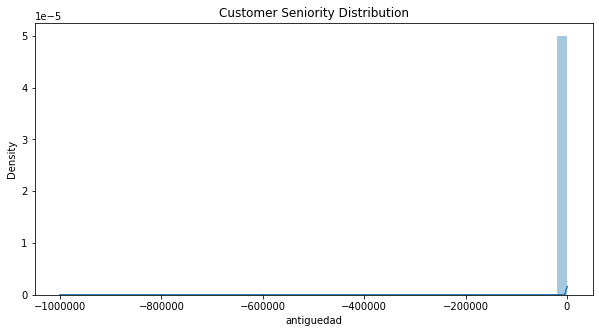

In [33]:
plt.figure(figsize=(10,5))
sns.distplot(df_group['antiguedad'])
plt.title('Customer Seniority Distribution')
plt.ticklabel_format(useOffset=False,style = 'plain',axis = 'x')
plt.show()

**Observations**
1. There are only three customers whose seniority < 0 i.e -999999 , and the rest all have seniority > 0.

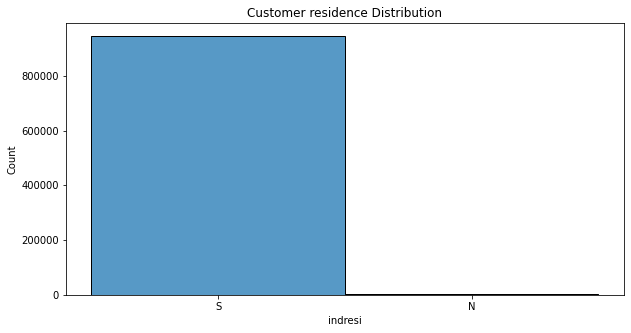

In [34]:
plt.figure(figsize=(10,5))
sns.histplot(df_group['indresi'])
plt.title('Customer residence Distribution')
plt.show()

**Observation**
1. Most customers' residence country is the **same** as that of the bank country.

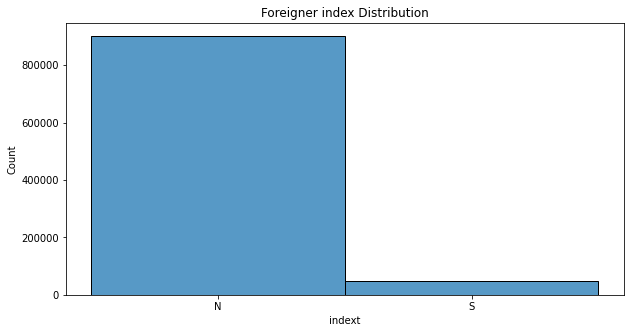

In [35]:
plt.figure(figsize=(10,5))
sns.histplot(df_group['indext'])
plt.title('Foreigner index Distribution')
plt.show()

**Observation**
1. Most customers' birth country is **not** **different** than that of the bank's country.

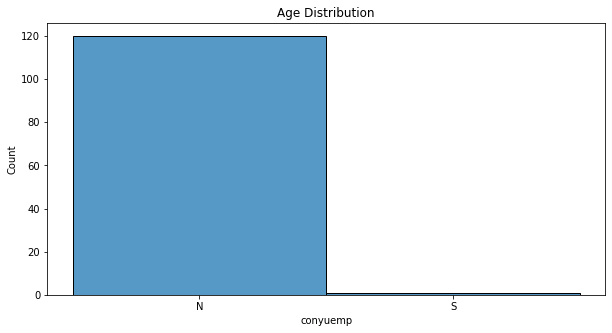

In [36]:
plt.figure(figsize=(10,5))
sns.histplot(df_group['conyuemp'])
plt.title('Age Distribution')
plt.show()

**Observation**
1. Most customers are **not** spouse of a bank employee.

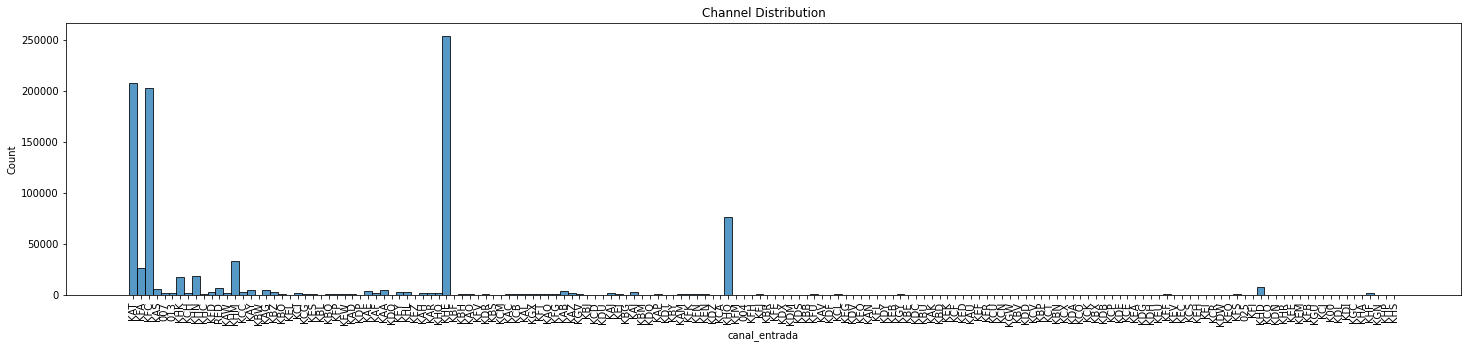

In [37]:
plt.figure(figsize=(25,5))
sns.histplot(df_group['canal_entrada'])
plt.title('Channel Distribution')
plt.xticks(rotation ='vertical')
plt.show()

**Observation**
1. Most customers joined the bank through the channels '**KHE**', '**KAT**', '**KFC**' and '**KHO**'


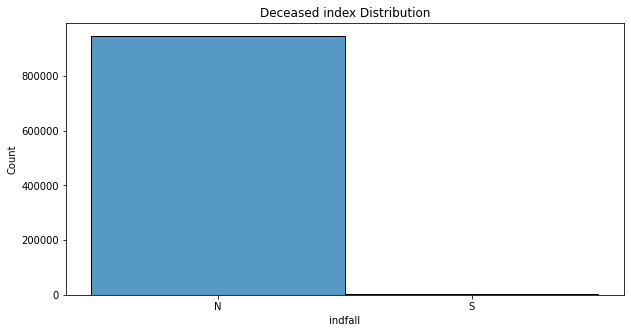

In [38]:
plt.figure(figsize=(10,5))
sns.histplot(df_group['indfall'])
plt.title('Deceased index Distribution')
plt.show()

**Observation**
1. Most customers of the bank are **not** deseased.

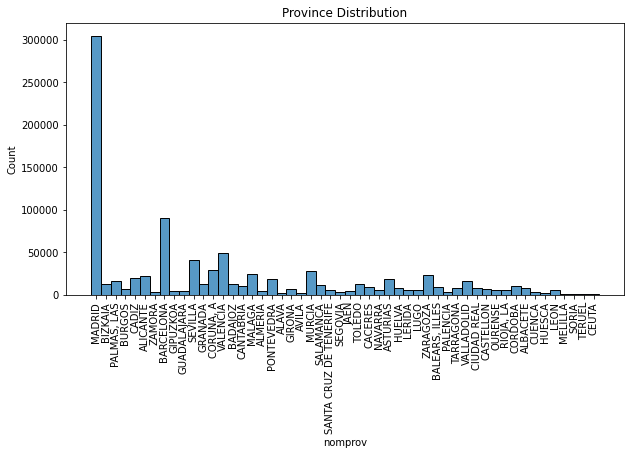

In [39]:
plt.figure(figsize=(10,5))
sns.histplot(df_group['nomprov'])
plt.title('Province Distribution')
plt.xticks(rotation ='vertical')
plt.show()

**Observation**
1. Most customers of the bank belong to province '**MADRID**' and '**BARCELONA**'

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


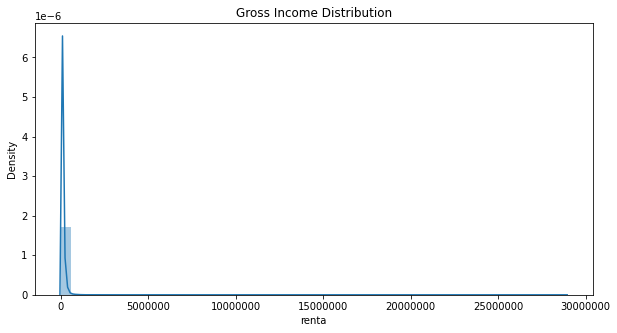

In [40]:
plt.figure(figsize=(10,5))
sns.distplot(df_group['renta'])
plt.title('Gross Income Distribution')
plt.ticklabel_format(useOffset=False,style = 'plain',axis = 'x')
plt.show()

**Observation**
1. 

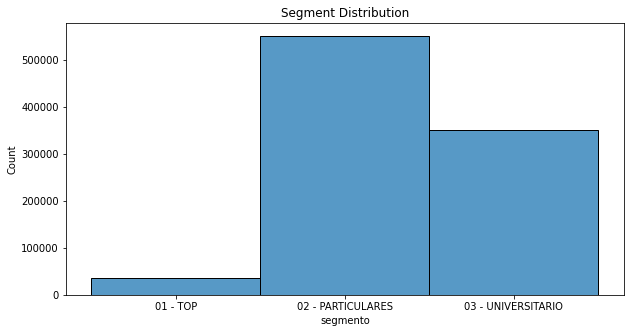

In [41]:
plt.figure(figsize=(10,5))
sns.histplot(df_group['segmento'])
plt.title('Segment Distribution')
plt.show()

**Observation**
1. Most customers of the bank are **individuals** and **college graduated**.
2. Bank has very less number of **VIPs**

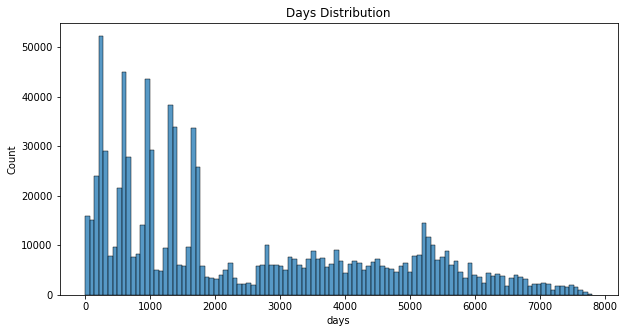

In [42]:
plt.figure(figsize=(10,5))
sns.histplot(df_group['days'])
plt.title('Days Distribution')
plt.show()

**Observation**
1. Most customers have been part of the bank since approx. **250**, **750**, **900** and **1200** days 

## Multivariate Analysis

### Distribution of products purchased every month

In [43]:
#Function to sum all values of the product columns

#https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns/53096340
def f(x):
    d = {}
    d['ahor'] = x['ind_ahor_fin_ult1'].sum()
    d['aval'] = x['ind_aval_fin_ult1'].sum()
    d['cco'] = x['ind_cco_fin_ult1'].sum()
    d['cder'] = x['ind_cder_fin_ult1'].sum()
    d['cno'] = x['ind_cno_fin_ult1'].sum()
    d['ctju'] = x['ind_ctju_fin_ult1'].sum()
    d['ctma'] = x['ind_ctma_fin_ult1'].sum()
    d['ctop'] = x['ind_ctop_fin_ult1'].sum()
    d['ctpp'] = x['ind_ctpp_fin_ult1'].sum()
    d['deco'] = x['ind_deco_fin_ult1'].sum()
    d['deme'] = x['ind_deme_fin_ult1'].sum()
    d['dela'] = x['ind_dela_fin_ult1'].sum()
    d['ecue'] = x['ind_ecue_fin_ult1'].sum()
    d['fond'] = x['ind_fond_fin_ult1'].sum()
    d['hip'] = x['ind_hip_fin_ult1'].sum()
    d['plan'] = x['ind_plan_fin_ult1'].sum()
    d['pres'] = x['ind_pres_fin_ult1'].sum()
    d['reca'] = x['ind_reca_fin_ult1'].sum()
    d['tjcr'] = x['ind_tjcr_fin_ult1'].sum()
    d['valo'] = x['ind_valo_fin_ult1'].sum()
    d['viv'] = x['ind_viv_fin_ult1'].sum()
    d['nomina'] = x['ind_nomina_ult1'].sum()
    d['nom_pens'] = x['ind_nom_pens_ult1'].sum()
    d['recibo'] = x['ind_recibo_ult1'].sum()
    return pd.Series(d, index=['ahor', 'aval', 'cco', 'cder', 'cno','ctju','ctma','ctop','ctpp','deco','deme','dela','ecue','fond','hip','plan','pres','reca','tjcr','valo','viv','nomina','nom_pens','recibo'])

In [44]:
products = df.groupby('fecha_dato').apply(f).columns
dates = df.fecha_dato.unique()

In [45]:
# count of products purchased every month
df.groupby('fecha_dato').apply(f)

,ahor,aval,cco,cder,cno,ctju,ctma,ctop,ctpp,deco,deme,dela,ecue,fond,hip,plan,pres,reca,tjcr,valo,viv,nomina,nom_pens,recibo
fecha_dato,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-28,88.0,19.0,487855.0,301.0,58763.0,7757.0,8418.0,106471.0,36195.0,1513.0,1620.0,36010.0,60381.0,13865.0,5007.0,7430.0,2349.0,38288.0,35613.0,20263.0,3234.0,39008.0,43328.0,95601.0
2015-02-28,89.0,20.0,488658.0,301.0,60028.0,7690.0,8228.0,106043.0,36040.0,2055.0,1596.0,35621.0,61080.0,14160.0,4998.0,7407.0,2344.0,38507.0,34352.0,20198.0,3219.0,40736.0,44768.0,94543.0
2015-03-28,89.0,21.0,489074.0,315.0,60929.0,7674.0,7875.0,105688.0,35847.0,2396.0,1560.0,34905.0,61979.0,14545.0,4988.0,7384.0,2340.0,38727.0,34990.0,20020.0,3196.0,42880.0,44032.0,97211.0
2015-04-28,87.0,21.0,489069.0,313.0,62221.0,7653.0,7482.0,105167.0,35650.0,2439.0,1512.0,34909.0,62677.0,14860.0,4968.0,7370.0,2346.0,39603.0,35988.0,19939.0,3173.0,42496.0,46624.0,98312.0
2015-05-28,85.0,21.0,489737.0,313.0,63391.0,7647.0,7096.0,104947.0,35499.0,2075.0,1476.0,35107.0,63604.0,15094.0,4797.0,7363.0,2342.0,39946.0,35880.0,19955.0,3155.0,41376.0,42368.0,96487.0
2015-06-28,83.0,21.0,494027.0,316.0,59845.0,7596.0,6920.0,104602.0,35342.0,1803.0,1444.0,35085.0,64096.0,15064.0,4721.0,7363.0,2040.0,42888.0,36550.0,19675.0,3138.0,43552.0,47648.0,98655.0
2015-07-28,82.0,19.0,503903.0,320.0,61607.0,7582.0,6939.0,104288.0,35145.0,1845.0,1396.0,34995.0,64479.0,15012.0,4707.0,7345.0,2024.0,41779.0,37159.0,19699.0,3128.0,45024.0,49536.0,99981.0
2015-08-28,82.0,19.0,514827.0,323.0,62997.0,7556.0,6993.0,104053.0,35010.0,1909.0,1378.0,34942.0,64793.0,15063.0,4693.0,7346.0,2023.0,42021.0,36820.0,19949.0,3108.0,42720.0,47040.0,96045.0
2015-09-28,81.0,19.0,529608.0,319.0,63759.0,7521.0,7180.0,103680.0,34795.0,1982.0,1362.0,35076.0,65071.0,15046.0,4682.0,7343.0,2024.0,42267.0,36248.0,20155.0,3090.0,43712.0,47968.0,100726.0


100%|██████████| 17/17 [01:12<00:00,  4.29s/it]


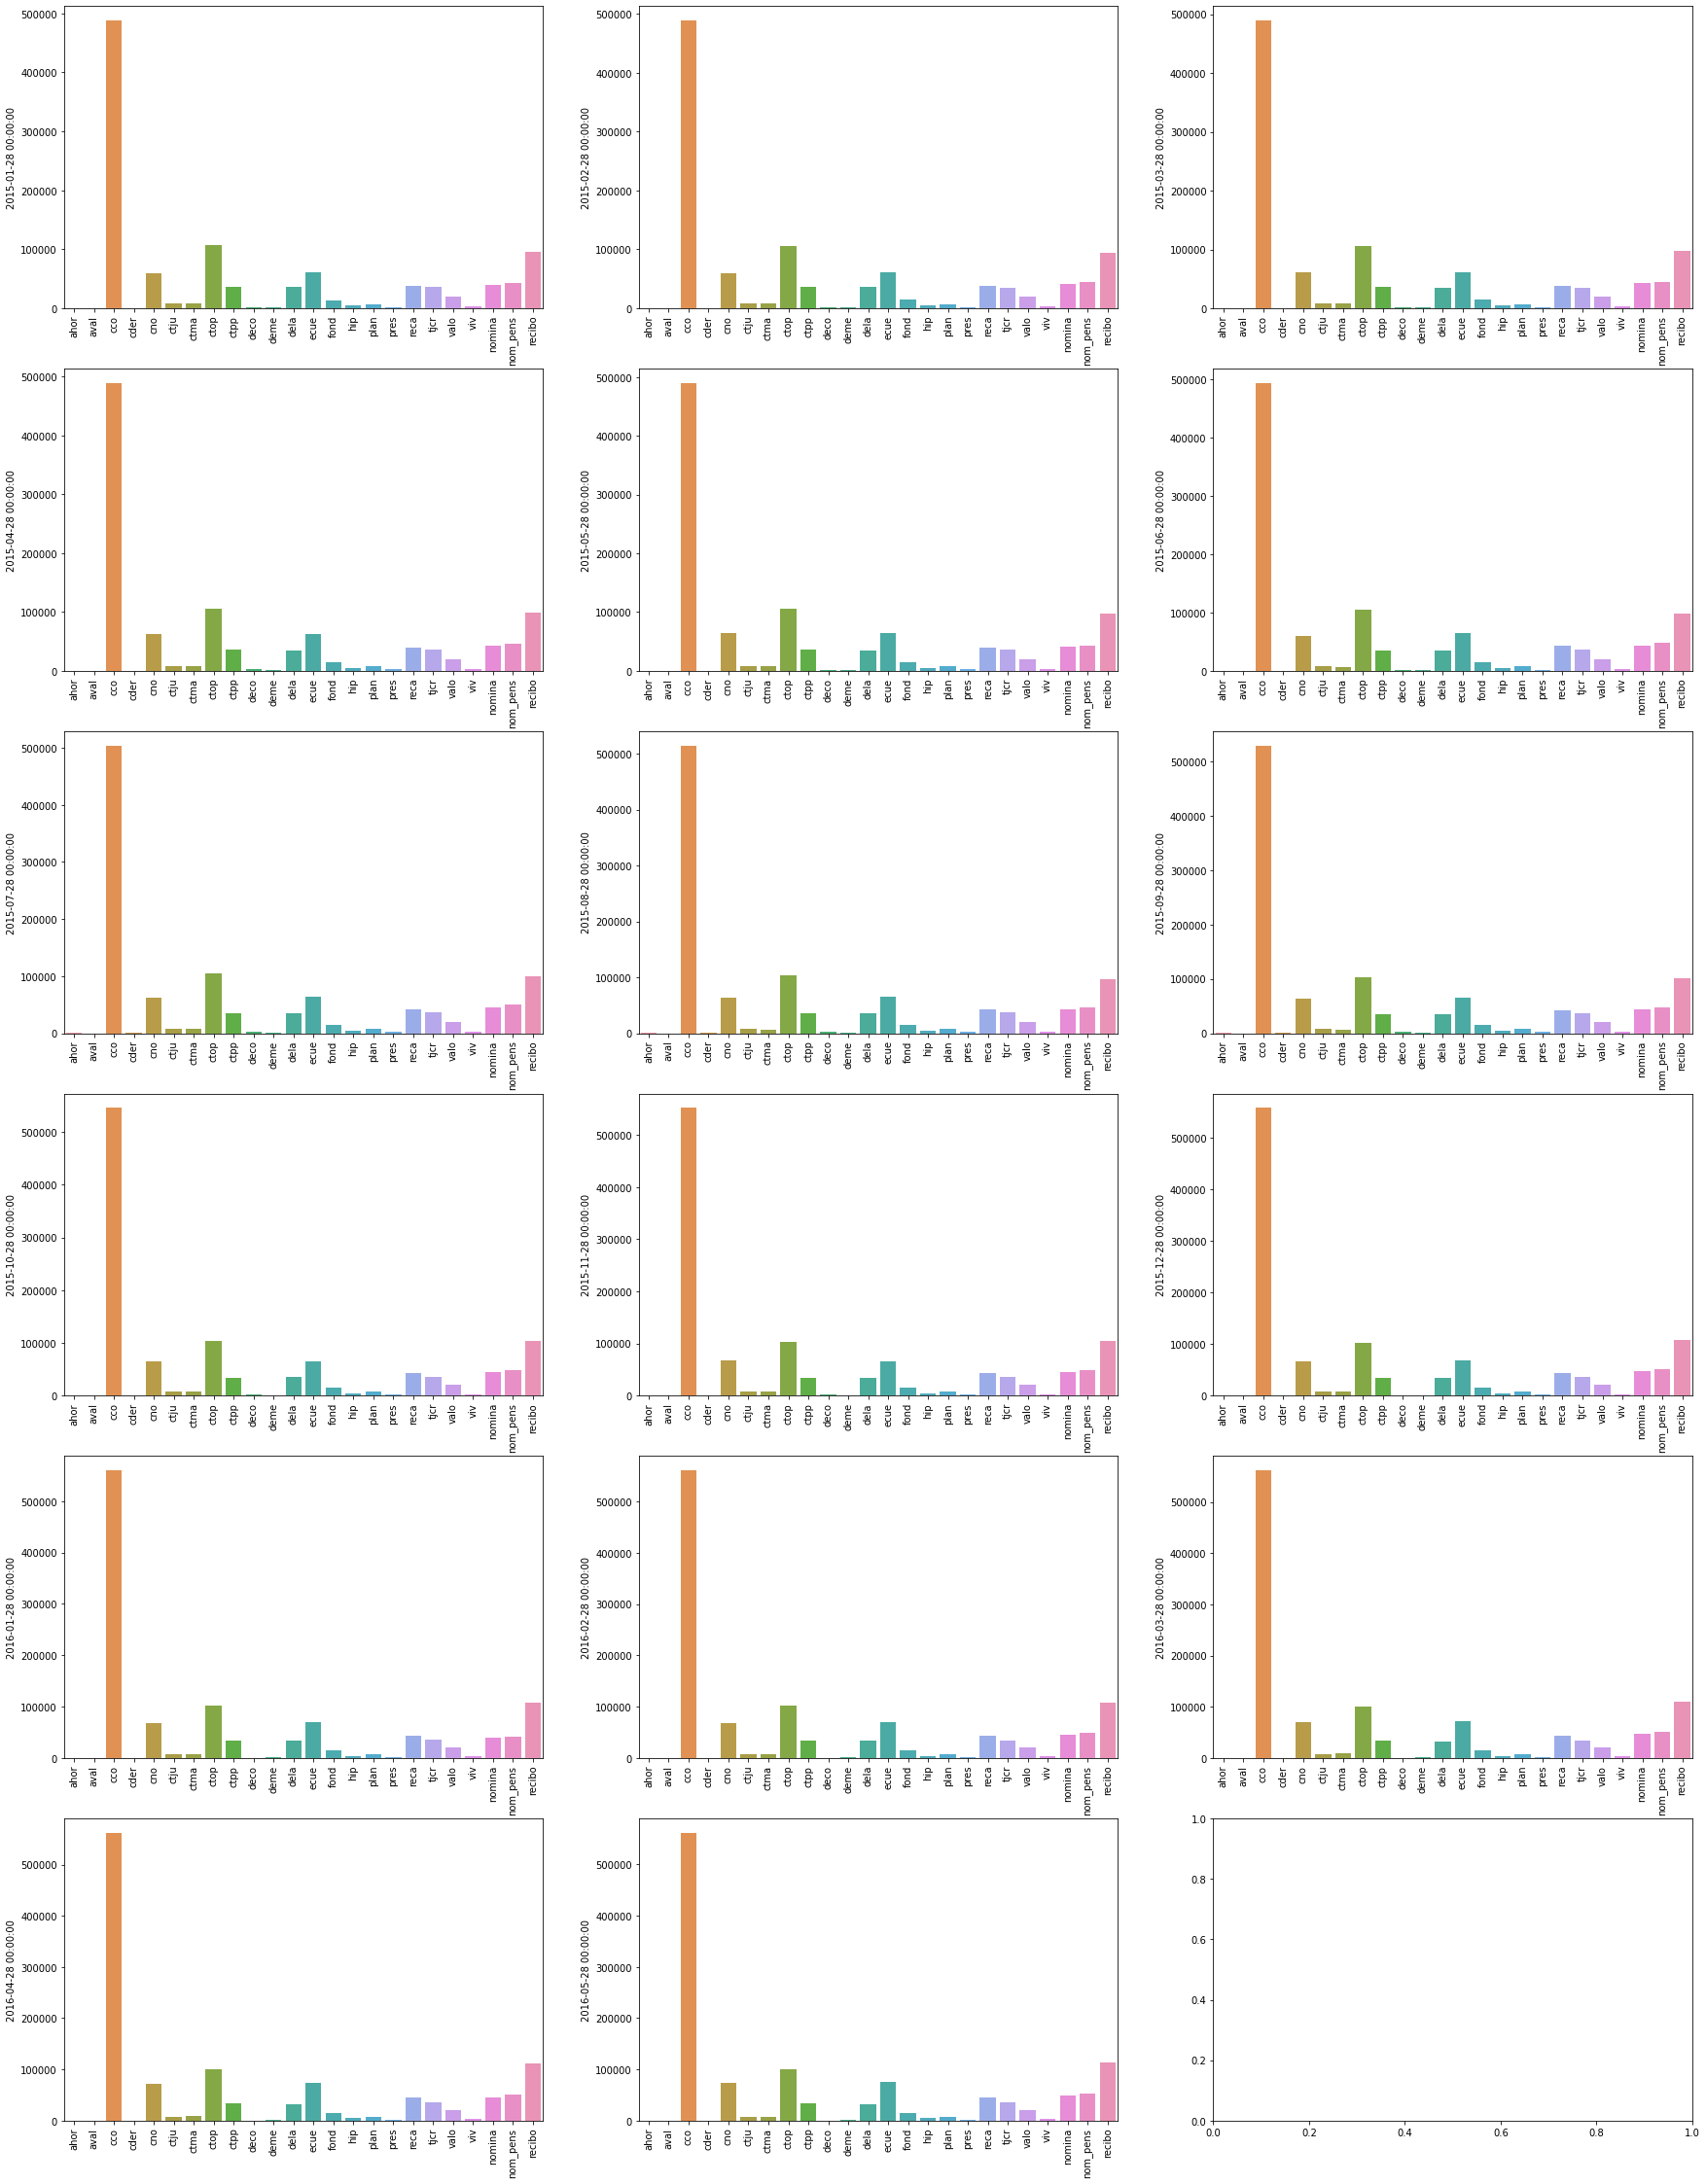

In [46]:
#plot of distribution of products purchased every month
a=0
b=0
fig, ax = plt.subplots(6, 3,figsize=(30,40))
for i in tqdm(dates):
    if(b>2):
        b=0
        a+=1
    sns.barplot(x = products, y  = df.groupby('fecha_dato').apply(f).loc[i], ax = ax[a,b])
    plt.setp(ax[a,b].xaxis.get_majorticklabels(), rotation=90)
    b+=1
plt.show()

**Observation**
1. product **cco** is purchased the most every month.
2. distribution of products purchased every month is same.
3. products **ahor** and **aval** were bought the least every month.

### Distribution of number of new products purchased every month.

In [47]:
num_new_prods = pd.DataFrame(columns = ['Month',1,2,3,4,5,6,7])

100%|██████████| 16/16 [00:44<00:00,  2.76s/it]


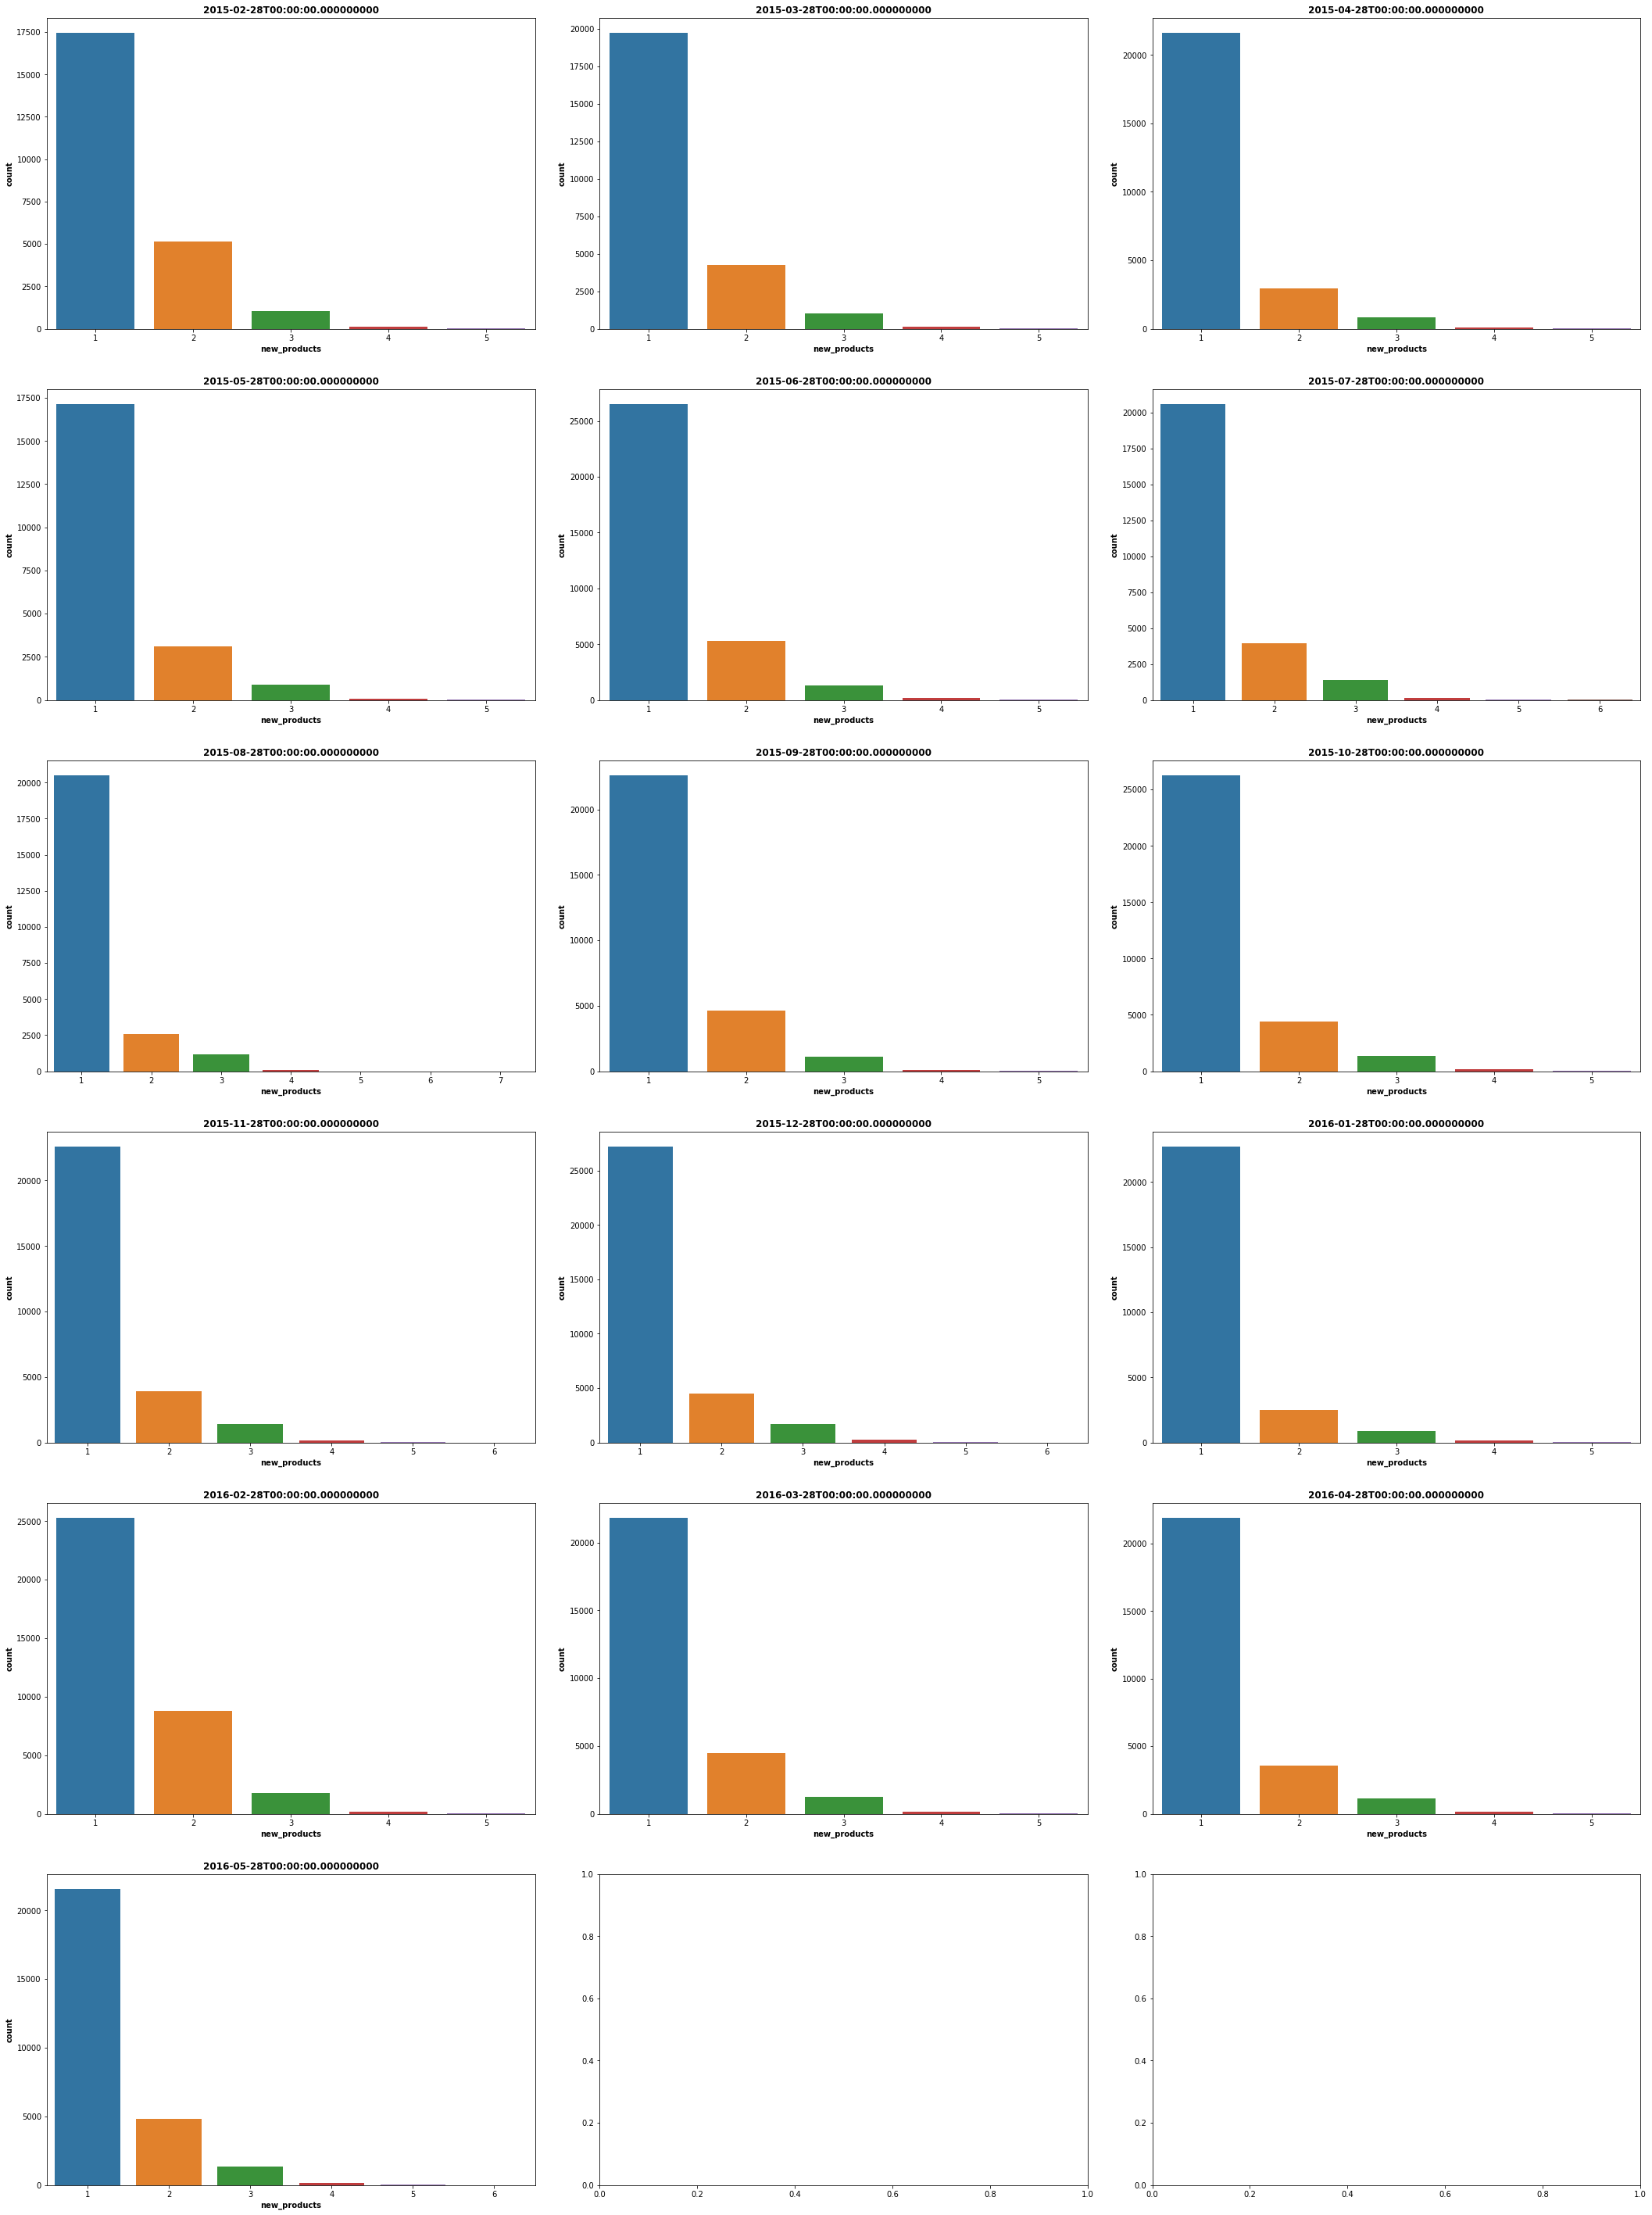

In [48]:
a=b=0
fig, ax = plt.subplots(6, 3,figsize=(30,40))
for i in tqdm(range(len(dates) - 1)):
    if(b>2):
        b=0
        a+=1
    prev_month = df[df['fecha_dato'] == dates[i]].set_index(['ncodpers']).iloc[:,21:]
    prev_month_customers = df[df['fecha_dato'] == dates[i]]['ncodpers'].to_numpy()
    next_month = df[(df['fecha_dato'] == dates[i+1]) & (df['ncodpers'].isin(prev_month_customers))].set_index(['ncodpers']).iloc[:,21:]
    new_prod = (prev_month - next_month)
    q = (new_prod[['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']] == -1).sum(1)
    dicts = collections.Counter(q[q > 0])
    #dicts = {str(k):v for k,v in dicts.items()}
    d = {'Month':dates[i+1]}
    d.update(dicts)
    num_new_prods = num_new_prods.append(d, ignore_index = True)
    sns.barplot(x = list(dicts.keys()), y  = list(dicts.values()), ax = ax[a,b])
    #plt.setp(ax[a,b].xaxis.get_majorticklabels(), rotation=90)
    ax[a,b].set_xlabel('new_products', fontweight ='bold')
    ax[a,b].set_ylabel('count', fontweight ='bold')
    ax[a,b].set_title(dates[i+1],fontweight ='bold')
    b+=1
fig.tight_layout(pad=3.0)
plt.show()

**Observation**
1. Most customers bought 1 new product every month followed by 2,3,4,& 5 new products in decreasing order.
2. In months like 2015-July, Nov, Dec & 2016-May few customers bought 6 new products.
3. In month 2015-Aug few customers bought 7 new products at a time.

In [49]:
# dataframe of the above plot
num_new_prods

,Month,1,2,3,4,5,6,7
0,2015-02-28,17466,5161,1043,105,7,NaN,NaN
1,2015-03-28,19757,4268,1038,129,5,NaN,NaN
2,2015-04-28,21619,2939,831,98,9,NaN,NaN
3,2015-05-28,17146,3101,864,89,3,NaN,NaN
4,2015-06-28,26532,5305,1327,148,6,NaN,NaN
5,2015-07-28,20595,3928,1401,159,12,2,NaN
6,2015-08-28,20515,2567,1141,100,1,1,1
7,2015-09-28,22620,4631,1104,118,6,NaN,NaN
8,2015-10-28,26272,4439,1344,144,9,NaN,NaN
9,2015-11-28,22600,3884,1377,160,14,1,NaN


### Distribution of new products added every month

In [50]:
new_prods = ['Month','ahor', 'aval', 'cco', 'cder', 'cno','ctju','ctma','ctop','ctpp','deco','deme','dela','ecue','fond','hip','plan','pres','reca','tjcr','valo','viv','nomina','nom_pens','recibo']

In [51]:
new_prods = pd.DataFrame(columns = new_prods)

100%|██████████| 16/16 [00:43<00:00,  2.72s/it]


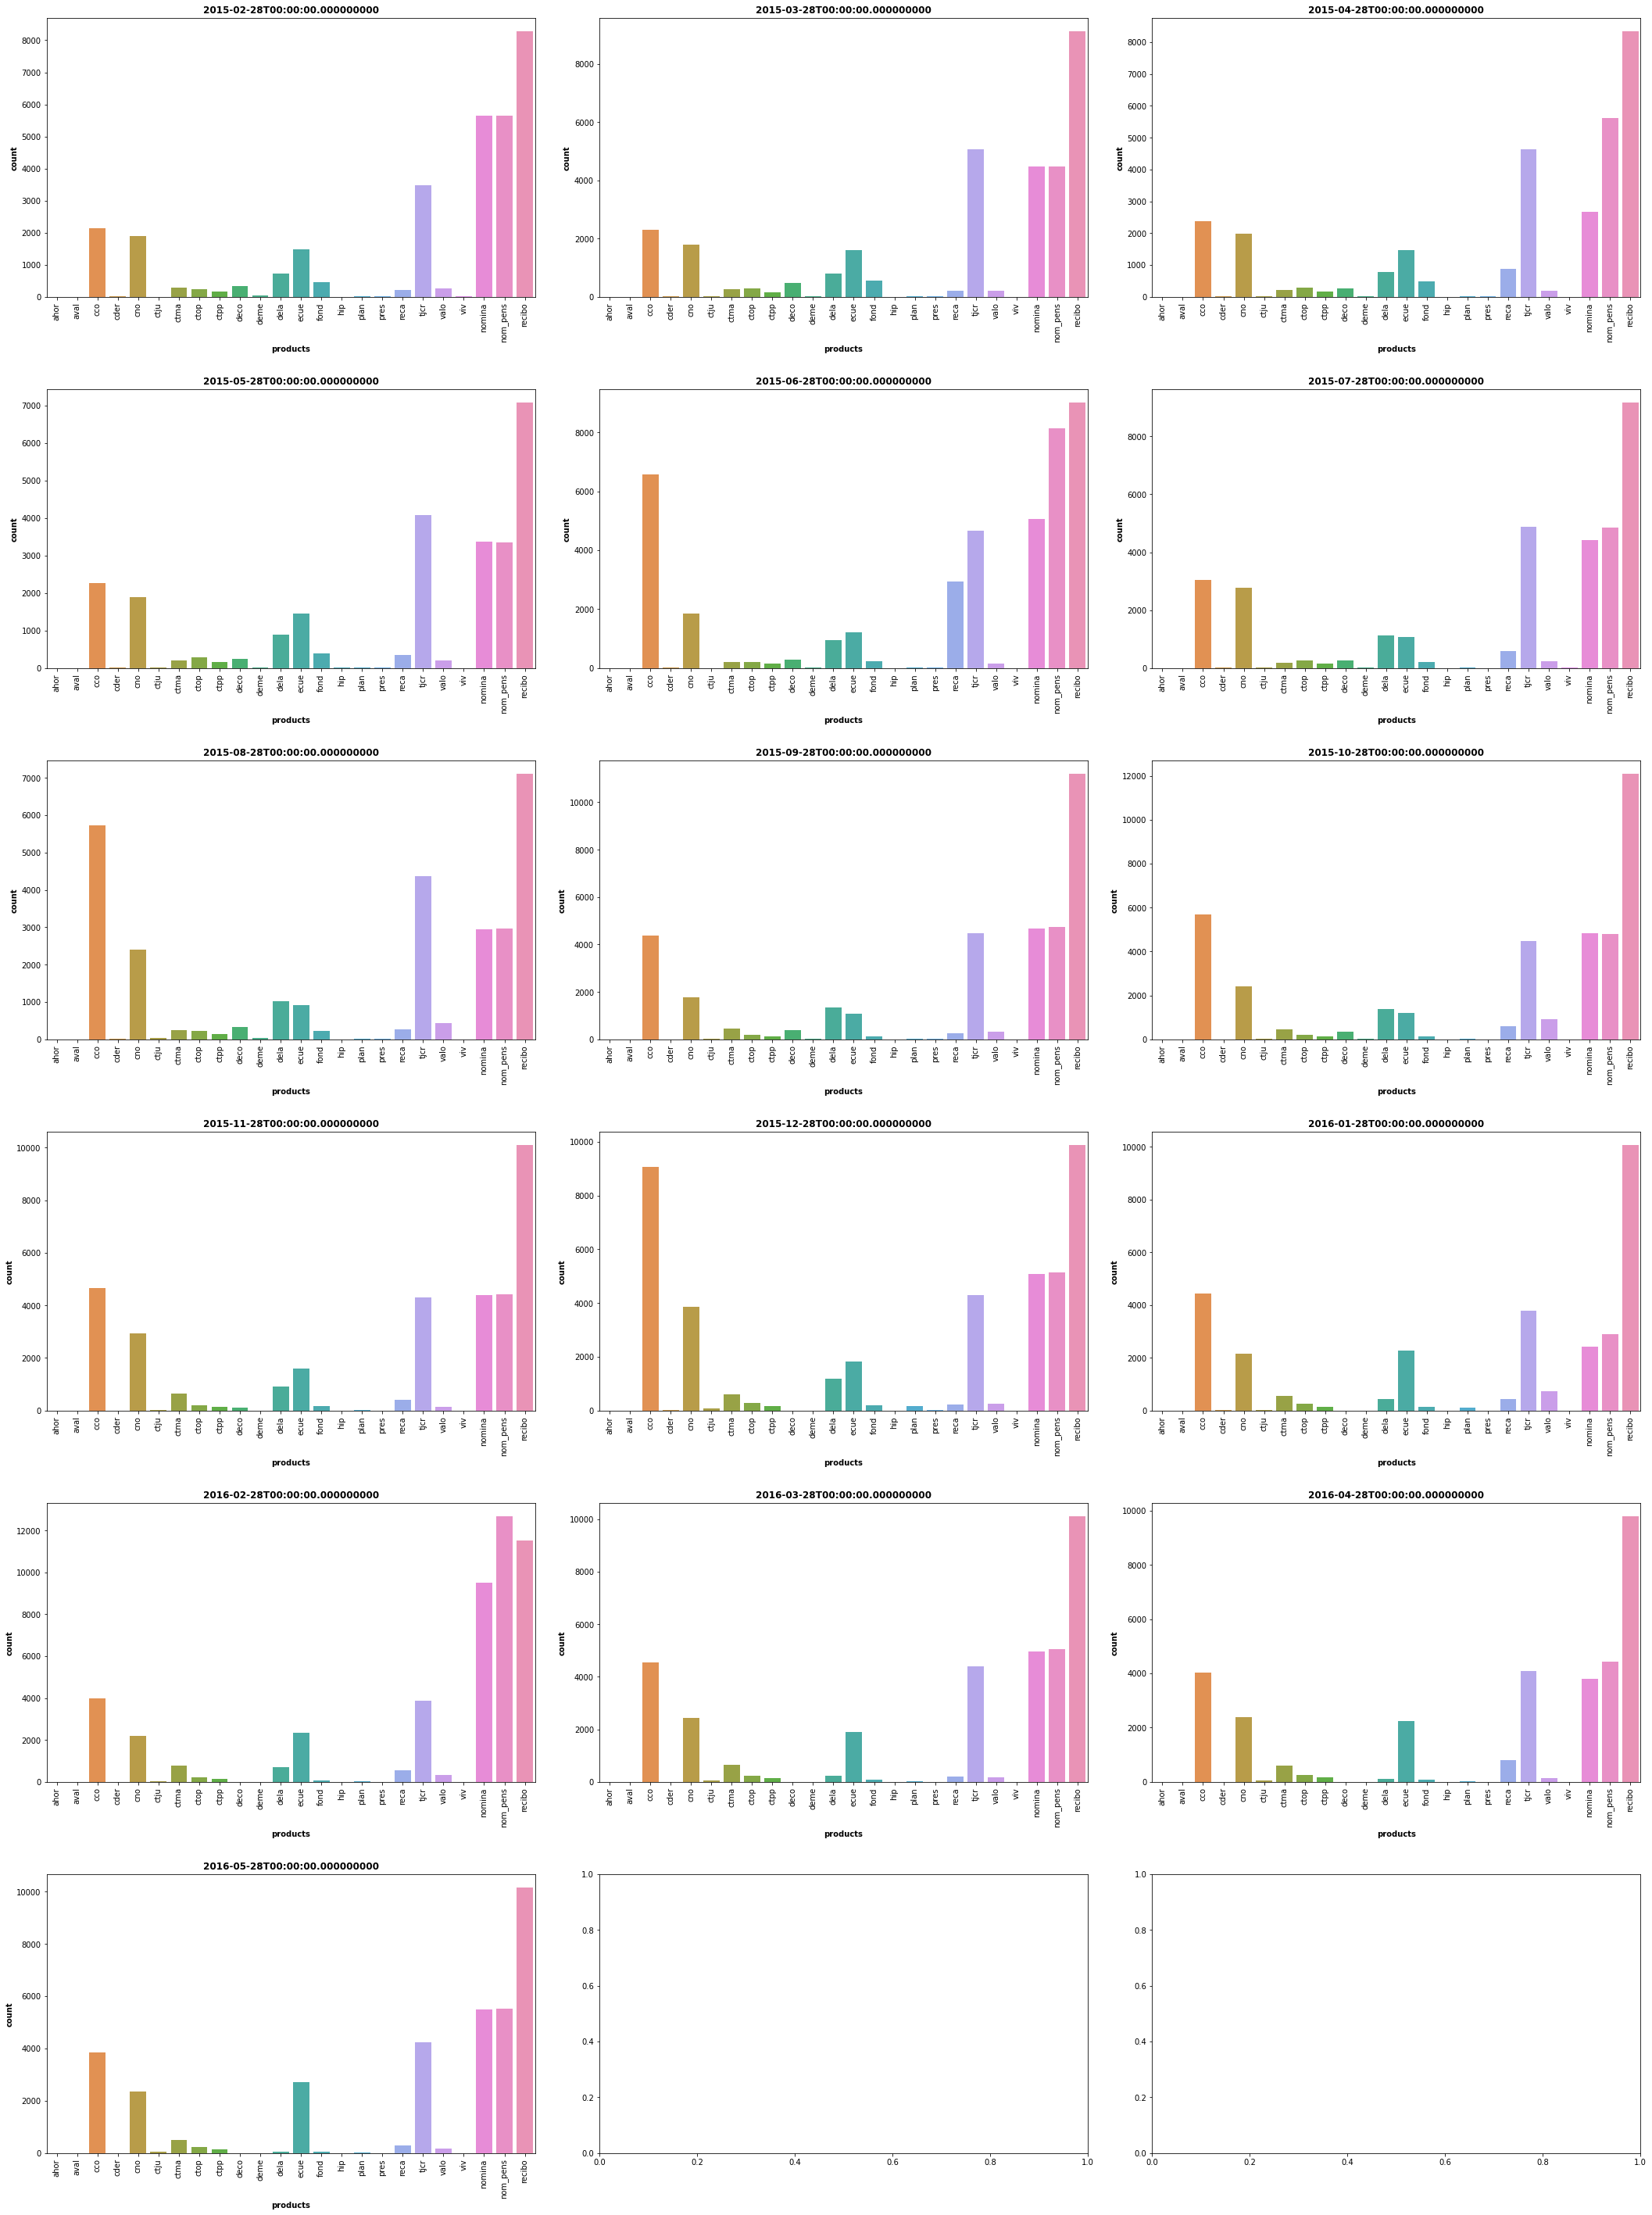

In [52]:
a=b=0
fig, ax = plt.subplots(6, 3,figsize=(30,40))
new_prods_dict = {}
for i in tqdm(range(len(dates) - 1)):
    if(b>2):
        b=0
        a+=1
    prev_month = df[df['fecha_dato'] == dates[i]].set_index(['ncodpers']).iloc[:,21:]
    prev_month_customers = df[df['fecha_dato'] == dates[i]]['ncodpers'].to_numpy()
    next_month = df[(df['fecha_dato'] == dates[i+1]) & (df['ncodpers'].isin(prev_month_customers))].set_index(['ncodpers']).iloc[:,21:]
    new_prod = (prev_month - next_month)
    new_products = np.zeros((24,))
    for j in range(24):
        new_products[j] = len(new_prod.iloc[:,j][new_prod.iloc[:,j] == -1])

    new_prods_dict['Month'] = dates[i+1]

    for k in range(len(products)):
        new_prods_dict[products[k]] = new_products[k]

    new_prods = new_prods.append(new_prods_dict, ignore_index = True)
    
    sns.barplot(x = products, y  = new_products, ax = ax[a,b])
    plt.setp(ax[a,b].xaxis.get_majorticklabels(), rotation=90)
    ax[a,b].set_xlabel('products', fontweight ='bold')
    ax[a,b].set_ylabel('count', fontweight ='bold')
    ax[a,b].set_title(dates[i+1],fontweight ='bold')
    b+=1
fig.tight_layout(pad=3.0)
plt.show()

**Observation**
1. In all the months products **ahor** & **aval** where bought very very few times as a new product.
2. In the month 2015-July products **reca** & **cco** was bought a lot of times compared to all other months.

In [53]:
# dataframe of the above plot
new_prods

,Month,ahor,aval,cco,cder,cno,ctju,ctma,ctop,ctpp,deco,deme,dela,ecue,fond,hip,plan,pres,reca,tjcr,valo,viv,nomina,nom_pens,recibo
0,2015-02-28,1.0,1.0,2132.0,12.0,1884.0,7.0,291.0,249.0,171.0,348.0,33.0,724.0,1472.0,451.0,5.0,27.0,9.0,217.0,3471.0,259.0,8.0,5659.0,5656.0,8285.0
1,2015-03-28,0.0,1.0,2293.0,15.0,1786.0,18.0,272.0,284.0,165.0,481.0,23.0,814.0,1594.0,570.0,7.0,24.0,12.0,217.0,5076.0,205.0,4.0,4479.0,4473.0,9135.0
2,2015-04-28,0.0,1.0,2366.0,12.0,1984.0,10.0,217.0,278.0,167.0,263.0,26.0,775.0,1459.0,492.0,4.0,22.0,17.0,871.0,4627.0,194.0,5.0,2663.0,5628.0,8346.0
3,2015-05-28,0.0,0.0,2264.0,7.0,1900.0,10.0,205.0,289.0,172.0,238.0,25.0,885.0,1461.0,396.0,9.0,21.0,11.0,343.0,4071.0,201.0,4.0,3369.0,3345.0,7085.0
4,2015-06-28,0.0,0.0,6588.0,9.0,1857.0,7.0,210.0,213.0,151.0,289.0,33.0,939.0,1204.0,245.0,4.0,19.0,8.0,2931.0,4655.0,152.0,3.0,5070.0,8135.0,9023.0
5,2015-07-28,0.0,0.0,3056.0,10.0,2771.0,18.0,191.0,252.0,164.0,265.0,24.0,1138.0,1085.0,204.0,6.0,27.0,5.0,589.0,4886.0,232.0,9.0,4408.0,4850.0,9172.0
6,2015-08-28,0.0,0.0,5730.0,10.0,2412.0,37.0,240.0,231.0,145.0,322.0,33.0,1024.0,924.0,223.0,1.0,22.0,13.0,264.0,4379.0,445.0,2.0,2950.0,2968.0,7115.0
7,2015-09-28,0.0,0.0,4389.0,7.0,1775.0,22.0,471.0,191.0,122.0,387.0,30.0,1348.0,1072.0,130.0,8.0,21.0,13.0,271.0,4463.0,328.0,2.0,4683.0,4753.0,11210.0
8,2015-10-28,0.0,0.0,5682.0,3.0,2409.0,43.0,468.0,223.0,153.0,349.0,22.0,1390.0,1205.0,146.0,7.0,19.0,9.0,593.0,4461.0,911.0,2.0,4818.0,4790.0,12100.0
9,2015-11-28,0.0,0.0,4670.0,6.0,2930.0,31.0,633.0,209.0,140.0,110.0,1.0,908.0,1588.0,169.0,3.0,37.0,8.0,416.0,4312.0,133.0,5.0,4395.0,4409.0,10102.0


Now we remove **ahor** & **aval** because they have the least chance of getting chosen in the top 7 product recommendation

In [54]:
df.drop(columns=['ind_ahor_fin_ult1', 'ind_aval_fin_ult1'],inplace = True)

Customer product purchase data without their demographic data

In [55]:
df.iloc[:,22:]

,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13647304,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647305,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647306,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
13647307,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0
